In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(12, 10)})
# sns.set(font_scale = 2)

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Insert dataframes

In [3]:
cwd = os.getcwd()

In [4]:
full_df_no_duplicates = pd.read_pickle(cwd + '/data/full_df_no_duplicates.pkl')
grouped_df = pd.read_pickle(cwd + '/data/grouped_df.pkl')

#### Isolation Forest

In [5]:
from sklearn import ensemble
from sklearn.preprocessing import RobustScaler

In [6]:
def find_anomalies_isl(data,n_estimators,max_samples,contamination,max_features):
    isl_model = ensemble.IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, 
                max_features=max_features, bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(data)

    anomaly_score = isl_model.decision_function(data)
    predictions = isl_model.predict(data)
    return anomaly_score,predictions

In [7]:
def find_margins(scores):
    median = np.median(scores)
    upper_quartile = np.percentile(scores, 75)
    lower_quartile = np.percentile(scores, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = scores[scores<=upper_quartile+1.5*iqr].max()
    lower_whisker = scores[scores>=lower_quartile-1.5*iqr].min()
    return upper_whisker,lower_whisker

In [8]:
def scale(data,column):
    scaled = []
    # define Robust scaler
    scaler = RobustScaler()
    # transform data
    scaled = scaler.fit_transform(data[[column]])

    return scaled

In [9]:
full_df_no_duplicates

,hash_id,date,lines_added,lines_deleted,project,Packages
0,000899acba05e5b9a2a630d59164ba055553e278,2017-06-24,1,1,log4j,[log4j-api-message]
1,0016185419e35dc903d0098689cb00326500f054,2021-12-26,25,1,jackson-databind,[deser]
2,001aaada7dab82c3c09cde5f8e14245dc9d8b454,2021-11-29,84,54,log4j,"[log4j-core-util, log4j-core-pattern]"
3,001bd2f7ae2997652bf3ac8e76a2a545fae9924f,2014-09-14,12,8,log4j,[log4j-core-util]
4,00255f2d013ad688c9fceade16fe478da572005d,2013-12-10,2,1,jackson-databind,[ser]
...,...,...,...,...,...,...
8739,ffca20367627ab5ee2d597d1194e0f33efbe303d,2015-09-11,3,3,log4j,[log4j-core-config]
8740,ffcdaadcccb3dfd61fae2661c5c72b842370f6ce,2019-07-29,17,4,jackson-databind,[type]
8741,ffd2e9a8f173a691bf329819cdc2a74751a5b15b,2015-11-02,3,1,log4j,[log4j-core-filter]
8742,ffedf33f170c8f0f8cc9bd943c2175ac73bf5d77,2016-04-20,124,1,log4j,[log4j-core-layout]


In [10]:
grouped_df

,commits_24h,changes_24h_lines_added,changes_24h_lines_removed,commits_7d,changes_7d_lines_added,changes_7d_lines_removed
date,,,,,,
2010-01-03,3,921,3,3,921,3
2010-01-09,4,16,14,7,937,17
2010-01-16,2,9,10,2,9,10
2010-01-21,1,9,9,3,18,19
2010-01-25,3,12,17,4,21,26
...,...,...,...,...,...,...
2022-04-19,4,26,43,7,1115,339
2022-04-20,7,252,30,13,755,123
2022-04-21,2,11,20,15,766,143


In [11]:
#Year range in the dataset
years = int((grouped_df.index.max() - grouped_df.index.min()).days / 365.2425)
print("Years in grouped_df:", years)
#We want to have the last 2 years
print("Last date of the dataset:",grouped_df.index.max())

Years in grouped_df: 12
Last date of the dataset: 2022-04-27


In [12]:
grouped_df_short = grouped_df.loc[pd.to_datetime('2020-04-27'):]

In [13]:
#Scale the data
grouped_df_short['commits_scaled'] = scale(grouped_df_short,'commits_7d')
grouped_df_short['lines_added_scaled'] = scale(grouped_df_short,'changes_7d_lines_added')
grouped_df_short['lines_removed_scaled'] = scale(grouped_df_short,'changes_7d_lines_removed')

### Evaluation

#### Isolation Forest - Different contamination level cutoffs

In [21]:
isl_anomaly_score_sftw, isl_predictions_sftw = find_anomalies_isl(grouped_df_short[['commits_scaled','lines_added_scaled','lines_removed_scaled']],
                                                n_estimators = 100,max_samples = 300,contamination = 0.07,max_features = 3)


Text(0.5, 1.0, 'Anomaly scores distributions')

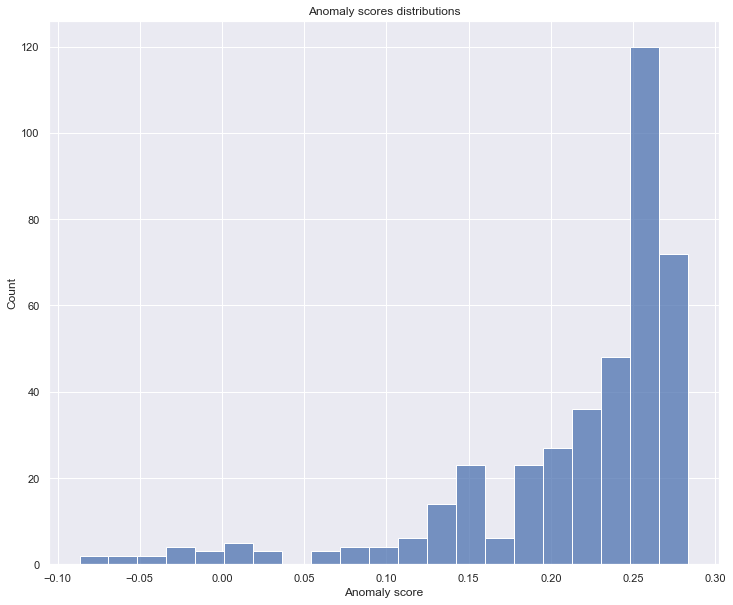

In [15]:
sns.histplot(isl_anomaly_score_sftw)
plt.xlabel("Anomaly score")
plt.title("Anomaly scores distributions")
#plt.savefig("Anomalies_histogram.png")

In [37]:
len(isl_anomaly_score_sftw[isl_anomaly_score_sftw < -0.05])/len(isl_anomaly_score_sftw)

0.051597051597051594

From the distribution of the anomaly scores we can see that approximately 5% of the data could be potentially anomalous. So, we are going to experiment with values of the contamination level parameter around **0.05**.

In [22]:
software_isl = grouped_df_short
software_isl['predictions_ISL_0,07'] = isl_predictions_sftw
software_isl[software_isl['predictions_ISL_0,07'] == -1]

,commits_24h,changes_24h_lines_added,changes_24h_lines_removed,commits_7d,changes_7d_lines_added,changes_7d_lines_removed,commits_scaled,lines_added_scaled,lines_removed_scaled,"predictions_ISL_0,03","predictions_ISL_0,05","predictions_ISL_0,07"
date,,,,,,,,,,,,
2020-06-13,20,870,787,43,2890,1557,2.909091,1.948984,2.757261,1,1,-1
2020-06-17,8,5319,1791,44,7336,3183,3.000000,6.149268,6.130705,-1,-1,-1
2020-06-18,13,267,118,55,7559,3293,4.000000,6.359943,6.358921,-1,-1,-1
2020-06-19,6,160,43,54,6829,2926,3.909091,5.670288,5.597510,-1,-1,-1
2020-06-20,3,963,182,37,6922,2321,2.363636,5.758148,4.342324,-1,-1,-1
2020-06-21,1,7,5,33,6843,2180,2.000000,5.683514,4.049793,1,-1,-1
2020-06-22,2,6,6,34,6841,2186,2.090909,5.681625,4.062241,1,-1,-1
2020-06-23,4,120,32,37,6842,2177,2.363636,5.682570,4.043568,1,-1,-1
2020-06-24,15,1468,728,44,2991,1114,3.000000,2.044402,1.838174,1,1,-1


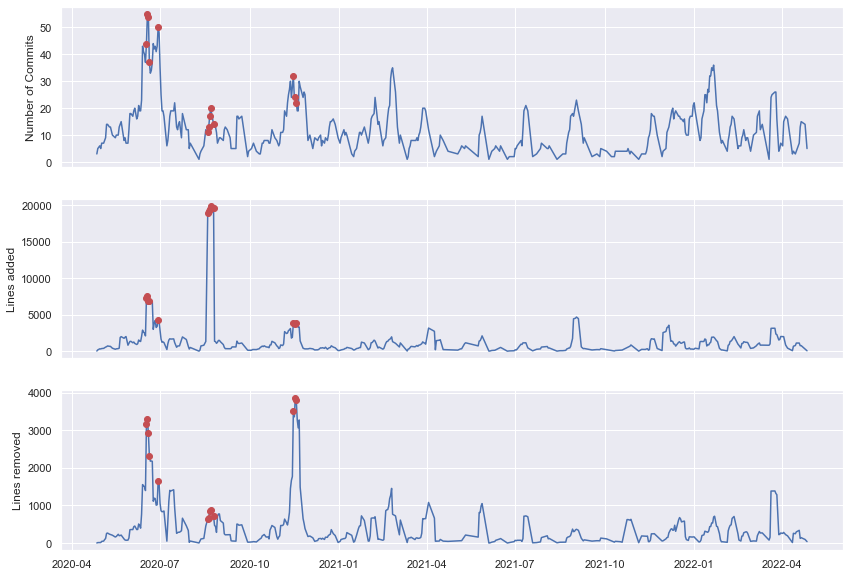

In [17]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14, 10), sharex=True)
ax[0].set_ylabel("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_isl[software_isl['predictions_ISL_0,03']==-1].index, software_isl[software_isl['predictions_ISL_0,03']==-1].commits_7d, 'ro')
ax[1].set_ylabel("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_isl[software_isl['predictions_ISL_0,03']==-1].index, software_isl[software_isl['predictions_ISL_0,03']==-1].changes_7d_lines_added, 'ro')
ax[2].set_ylabel("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_isl[software_isl['predictions_ISL_0,03']==-1].index, software_isl[software_isl['predictions_ISL_0,03']==-1].changes_7d_lines_removed, 'ro')
#plt.savefig("Contamination_0.03.png")


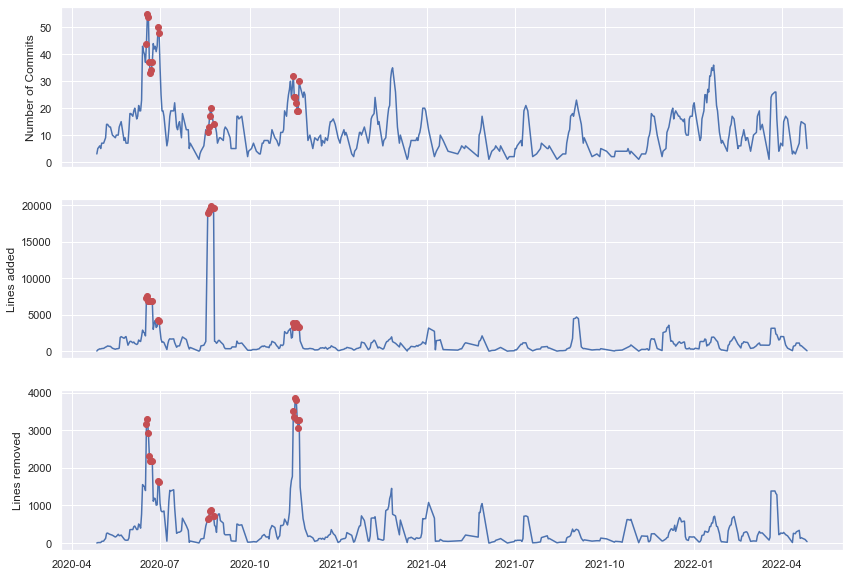

In [20]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14, 10), sharex=True)
ax[0].set_ylabel("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_isl[software_isl['predictions_ISL_0,05']==-1].index, software_isl[software_isl['predictions_ISL_0,05']==-1].commits_7d, 'ro')
ax[1].set_ylabel("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_isl[software_isl['predictions_ISL_0,05']==-1].index, software_isl[software_isl['predictions_ISL_0,05']==-1].changes_7d_lines_added, 'ro')
ax[2].set_ylabel("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_isl[software_isl['predictions_ISL_0,05']==-1].index, software_isl[software_isl['predictions_ISL_0,05']==-1].changes_7d_lines_removed, 'ro')
#plt.savefig("Contamination_0.05.png")


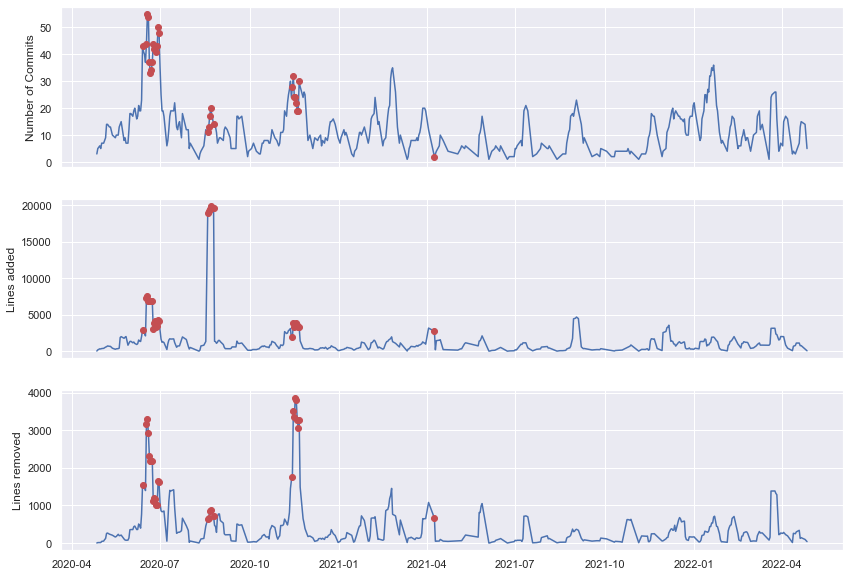

In [23]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14, 10), sharex=True)
ax[0].set_ylabel("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_isl[software_isl['predictions_ISL_0,07']==-1].index, software_isl[software_isl['predictions_ISL_0,07']==-1].commits_7d, 'ro')
ax[1].set_ylabel("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_isl[software_isl['predictions_ISL_0,07']==-1].index, software_isl[software_isl['predictions_ISL_0,07']==-1].changes_7d_lines_added, 'ro')
ax[2].set_ylabel("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_isl[software_isl['predictions_ISL_0,07']==-1].index, software_isl[software_isl['predictions_ISL_0,07']==-1].changes_7d_lines_removed, 'ro')
#plt.savefig("Contamination_0.07.png")


In order to evaluate the performance of the novel Isolation Forest - Xmeans algorithm, a comparison is going to be made with simple implementations of the Isolation Forest algorithm. The only difference among the implementations is going to be the value of the contamination parameter. 


In order to try and eliminate the randomness in picking the value of the contamination anticipated in the data, we implement an initial Isolation Forest and get the anomaly scores for all the data points. The contamination level does not play a role until now. The distribution of the anomaly scores is visible in the histogram plot. From this, it can be inferred that approximately 3% of the data are anomalous. For that reason, the implementations of Isolation Forest are goint to be done with contamination levels equal to [ 0.03, 0.05, 0.07].


- Contamination level = 0.03
    - Only 5 points are identified as anomalies. Those points belong to the very large spikes of the time series, but even that does not seem to be properly identified because not all the points in the spikes are marked as anomalies. So, the algorithm fails to identify the whole sequence of the data. If ground truth was available, this implementation would suffer from False Negatives.

- Contamination level = 0.05 
    - In this case, the results seem reasonable and the whole sequence of data belonging to the huge spikes are marked as anomalies. This was anticipated since the distribution of the anomalies scores showed that approximately 3% of the data are anomalies. The results from this method are very close to the ones from IF-Xmeans.

- Contamination level = 0.07
    - Following the same pattern as before, more points are spotted both in the beginning of the time series and later. Also, more data points that belong to the large spikes are marked as anomalies. While, some extra anomalous points are identified with higher levels of contamination, also false positives start becoming visible.
    
    
By comparing the results of Isolation Forest implementations for different contamination levels, with the results of the proposed combination of Isolation Forest with Xmeans it is apparent that the combination identifies the obvious anomalies and successfully marks the whole sequence of the data, while also does not seem to give any False positives. In addition, probably the biggest advantage of Isolation Forest - Xmeans is that is achieves a certain independence from the contamination level parameter. Even if the results by specifying manually the value of the parameter are comparable and in certain cases similar to the ones of the combination, those approaches require previous domain knowledge or analysis of the data before the application of the algorithm. As a result, the combination of effective performance with the independence of manual specification of parameters makes the proposed method superior to simple Isolation Forest implementations.